# Fallback - Event Propensity Scoring
* StellarAlgo Data Science
* Ryan Kazmerik
* Oct 06, 2022

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.classification import *
from shared_utilities import helpers

In [2]:
CLUSTER = "prod-app"
DATABASE = "stlrflames"
LKUPCLIENTID = "36"

In [3]:
df_event_propensity_training = helpers.get_event_propensity_training_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    start_year=2010,
    end_year=2021
)

df_event_propensity_training.shape

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

LJNK-XBCR
Successfully logged into Start URL: https://stellaralgo.awsapps.com/start#/
Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(24850, 17)

In [4]:
df_event_propensity_training.head()

,daysout,mindaysout,maxdaysout,dimcustomermasterid,recent_openrate,recent_clickrate,eventdate,eventname,inmarket,distancetovenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventday,frequency_eventtime,count_merchowned
0,Over a Week,8,NaN,339847,0.0,0.0,2020-02-21,20200221 - Boston Bruins,True,7.03,1614,1,193,0.5,0.266667,0.245902,0
1,Over a Week,8,NaN,342949,0.0,0.0,2020-01-09,20200109 - Minnesota Wild,True,11.74,1142,1,134,0.0,0.000000,0.007937,0
2,Over a Week,8,NaN,343158,0.0,0.0,2021-11-27,20211127 - Winnipeg Jets,None,NaN,21,1,2,0.0,0.000000,0.000000,0
3,Over a Week,8,NaN,343552,0.0,0.0,2017-03-09,20170309 - Montreal Canadiens,False,204.53,169,1,32,0.0,0.250000,0.225806,0
4,Over a Week,8,NaN,343856,0.0,0.0,2019-12-29,20191229 - Vancouver Canucks,True,12.42,768,1,89,0.0,0.000000,0.012195,0


In [5]:
# choose the features for the stellar base retention model
features = [
    "daysout",
    "dimcustomermasterid",
    "did_purchase",
    "distancetovenue",
    "eventdate",
    "eventname",
    "events_purchased",
    "frequency_opponent",
    "frequency_eventday",
    "frequency_eventtime",
    "inmarket",
    "recent_openrate",
    "recent_clickrate",
    "tenure"
]

# copy your main dataframe
df_dataset = df_event_propensity_training

#creating the training and evaluation dataframe
df_dataset = df_dataset[features]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (21122, 14)
Unseen Data For Predictions: (3728, 14)



In [55]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimcustomermasterid",
        "eventdate",
        "eventname"
    ],
    silent=True,
    verbose=False,
    categorical_features=[
        "daysout"
    ],
    numeric_features=[
        "distancetovenue",
        "events_purchased",
        "frequency_opponent",
        "frequency_eventday",
        "frequency_eventtime",
        "inmarket",
        "recent_openrate",
        "recent_clickrate",
        "tenure"
    ]
);

In [56]:
model_matrix = compare_models(
    fold=10,
    include=["lr"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7605,0.8578,0.7416,0.7719,0.7564,0.5210,0.5215,0.1050


In [57]:
best_model = create_model(model_matrix);
final_model = finalize_model(best_model);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7667,0.8601,0.7547,0.7745,0.7645,0.5334,0.5336
1,0.7450,0.8506,0.7333,0.7517,0.7424,0.4900,0.4902
2,0.7695,0.8642,0.7411,0.7866,0.7632,0.5390,0.5399
3,0.7632,0.8640,0.7644,0.7636,0.7640,0.5265,0.5265
4,0.7755,0.8662,0.7444,0.7948,0.7688,0.5511,0.5522
5,0.7393,0.8425,0.7167,0.7517,0.7338,0.4786,0.4791
6,0.7638,0.8573,0.7478,0.7736,0.7605,0.5276,0.5279
7,0.7560,0.8563,0.7400,0.7655,0.7525,0.5120,0.5123
8,0.7549,0.8528,0.7222,0.7738,0.7471,0.5098,0.5110


In [58]:
df_gamedays = helpers.get_event_propensity_gamedays(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID
)

df_gamedays.head(3)

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


,game_date
0,2022-10-18
1,2022-10-20
2,2022-10-22


In [59]:
predictions =[]
for date in df_gamedays["game_date"][:6]:
    
    df_inference = helpers.get_event_propensity_scoring_dataset(
        cluster=CLUSTER,
        database=DATABASE,
        lkupclientid=LKUPCLIENTID,
        game_date=date
    )

    df_scores = predict_model(final_model, data=df_inference, raw_score=True)
    predictions.append(df_scores)

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com
Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com
Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com
Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com
Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com
Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


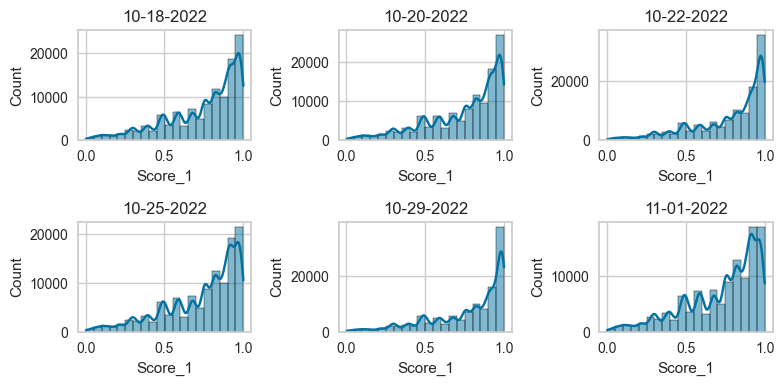

In [60]:
for idx, df_game in enumerate(predictions):
    
    plt.subplot(3, 3, idx+1)
    
    event_date = df_game['eventdate'].unique()[0].strftime("%m-%d-%Y")
    
    sns.histplot(data=df_game, x='Score_1', bins= 20, kde=True)    
    plt.title(event_date, fontsize = 12)

    #print(df_game["Score_1"].value_counts(bins=[0,0.8,0.9,1.0]))
    
plt.tight_layout()
plt.show()

In [61]:
for df_game in predictions:

    event_date = df_game['eventdate'].unique()[0].strftime("%m-%d-%Y")
    df_game.to_csv(f"data/scores_{event_date}.csv", index=False)